In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
#plt.rcParams['figure.dpi'] = 150

It seems that experimental noise does lead to more noise in the information footprint. However, my hypothesis is that the level of noise has to be bigger than the bin size (so as to facilitate a sufficient number of bin transitions) in order to lead to noise.

## Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

## Find the transcription start site
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

In [4]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [5]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

## Intial tests

### Assuming RNA count is normally distributed

In [6]:
def simrep_with_expt_noise(wtseq, rnap_wtseq, rep_wtseq, rnap_emat, O1_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r, noise_level=1,
                           num_mutants=1000, scaling_factor=100):
    
    mutants = np.unique(tregs.wgregseq.mutations_rand(wtseq,
                                       rate=0.1,
                                       num_mutants=num_mutants,
                                       number_fixed=True))

    rnap_start, rnap_end = tregs.seq_utils.find_binding_site(wtseq, rnap_wtseq)
    rep_start, rep_end = tregs.seq_utils.find_binding_site(wtseq, rep_wtseq)

    df_simrep = tregs.simulate.simrep_helper(mutants, rnap_start, rnap_end, rep_start, rep_end,
                                             rnap_emat, O1_emat, n_p, n_r, n_NS,
                                             ep_wt, er_wt)
    
    dna_cnt = tregs.simulate.get_dna_cnt(len(df_simrep))
    df_simrep['ct_0'] = dna_cnt
    df_simrep = df_simrep[df_simrep.ct_0 != 0.0]

    noise = 1 + np.random.normal(loc=0, scale=noise_level, size=num_mutants)
    df_simrep['ct_1'] = df_simrep['ct_0'] * df_simrep['pbound'] * scaling_factor
    df_simrep['ct_1'] = df_simrep['ct_1'].mul(noise, axis=0)
    df_simrep.loc[df_simrep['ct_1'] < 0, 'ct_1'] = 0
    df_simrep['ct_1'] = 1 + df_simrep['ct_1'].astype(int) # adding 1 as a pseudocount
    df_simrep['ct'] = df_simrep['ct_0'] + df_simrep['ct_1']

    df_simrep['ct'] = df_simrep['ct'].astype(float)
    df_simrep['ct_0'] = df_simrep['ct_0'].astype(float)
    df_simrep['ct_1'] = df_simrep['ct_1'].astype(float)
    df_simrep['norm_ct_1'] = df_simrep['ct_1'] / df_simrep['ct_0']

    return df_simrep

In [7]:
n_NS = len(genome)
ep_wt, er_wt = -5, -15
n_p = 4600
n_r = 15

df = simrep_with_expt_noise(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                            ep_wt, er_wt, n_NS, n_p, n_r, noise_level=2)
n_seqs = len(df)
mut_list = df['seq'].values
mu_data = df['norm_ct_1']

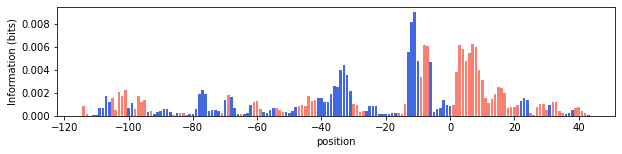

In [8]:
nbins = 2
upper_bound = 5
footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                               pseudocount=0)

exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter,
                                                    smoothed=True, windowsize=3)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]

fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
ax.bar(x, footprint, edgecolor=None, color=shiftcolors)

#plt.savefig('../figs/lacI_synthetic_footprint_5_15.png', dpi=300, bbox_inches='tight')
plt.show()

### Assuming RNA count exists on an exponential distribution

In [9]:
def simrep_with_expt_noise(wtseq, rnap_wtseq, rep_wtseq, rnap_emat, O1_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r, noise_level=1,
                           num_mutants=1000, scaling_factor=100):
    
    mutants = np.unique(tregs.wgregseq.mutations_rand(wtseq,
                                       rate=0.1,
                                       num_mutants=num_mutants,
                                       number_fixed=True))

    rnap_start, rnap_end = tregs.seq_utils.find_binding_site(wtseq, rnap_wtseq)
    rep_start, rep_end = tregs.seq_utils.find_binding_site(wtseq, rep_wtseq)

    df_simrep = tregs.simulate.simrep_helper(mutants, rnap_start, rnap_end, rep_start, rep_end,
                                             rnap_emat, O1_emat, n_p, n_r, n_NS,
                                             ep_wt, er_wt)
    
    dna_cnt = tregs.simulate.get_dna_cnt(len(df_simrep))
    df_simrep['ct_0'] = dna_cnt
    df_simrep = df_simrep[df_simrep.ct_0 != 0.0]

    noise = np.random.exponential(noise_level, size=num_mutants)
    df_simrep['ct_1'] = df_simrep['ct_0'] * df_simrep['pbound'] * scaling_factor
    df_simrep['ct_1'] = df_simrep['ct_1'].mul(noise, axis=0)
    df_simrep['ct_1'] = 1 + df_simrep['ct_1'].astype(int) # adding 1 as a pseudocount
    df_simrep['ct'] = df_simrep['ct_0'] + df_simrep['ct_1']

    df_simrep['ct'] = df_simrep['ct'].astype(float)
    df_simrep['ct_0'] = df_simrep['ct_0'].astype(float)
    df_simrep['ct_1'] = df_simrep['ct_1'].astype(float)
    df_simrep['norm_ct_1'] = df_simrep['ct_1'] / df_simrep['ct_0']

    return df_simrep

In [10]:
n_NS = len(genome)
ep_wt, er_wt = -5, -15
n_p = 4600
n_r = 15

df = simrep_with_expt_noise(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                            ep_wt, er_wt, n_NS, n_p, n_r, noise_level=1)
n_seqs = len(df)
mut_list = df['seq'].values
mu_data = df['norm_ct_1']

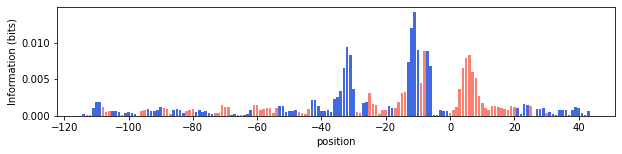

In [11]:
nbins = 2
upper_bound = 10
footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                               pseudocount=0)

exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter,
                                                    smoothed=True, windowsize=3)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]

fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
ax.bar(x, footprint, edgecolor=None, color=shiftcolors)

#plt.savefig('../figs/lacI_synthetic_footprint_5_15.png', dpi=300, bbox_inches='tight')
plt.show()